# Environment Setup

In [2]:
from config import *

import time
import numpy as np
import pandas as pd
#pd.options.display.max_columns = None
#pd.options.display.mpl_style = 'default'

import re
import os
import sys
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer('english')

## 1. Import raw data

In [3]:
df_train = pd.read_csv(DATA_DIR + '/train.csv', encoding="ISO-8859-1")
df_test = pd.read_csv(DATA_DIR + '/test_with_solutions.csv', encoding="ISO-8859-1")
df_val = pd.read_csv(DATA_DIR + '/impermium_verification_labels.csv', encoding="ISO-8859-1")
#df_train = pd.concat((df_train, df_test), axis=0, ignore_index=True)

In [4]:
def parser(text):
    # encode editor
    text = re.sub(r'\\\\', r'\\', text)
    text = re.sub(r'\\\\', r'\\', text)
    # remove non-break symbol
    text = re.sub(r'\\x\w{2,2}', ' ', text)
    text = re.sub(r'\\u\w{4,4}', ' ', text)
    text = text.replace("\\n"," ")         
    text = text.replace("\\t"," ")         
    text = text.replace("\\xa0"," ") 
    text = text.replace("\\xc2"," ") 
    
    # remove change line symbol
    text = text.replace('\\n\\n','. ')
    
    # Grammer
    text = text.replace("'ll", " will")
    text = text.replace("'LL", " WILL")
    text = text.replace("'d", " would")
    text = text.replace("'D", " WOULD")
    text = text.replace("n't", "nt")
    text = text.replace("N'T", "NT")
    text = text.replace("won't", "will not") 
    text = text.replace("can't", "cannot")
    text = text.replace("i'm", "i am") 
    text = text.replace(" im ", " i am ") 
    text = text.replace("ain't", "is not") 
    text = text.replace("'ve", " have") 
    text = text.replace("'s", " is") 
    text = text.replace("'re", " are") 
    
    text = text.replace(" u "," you ") 
    text = text.replace(" em "," them ")
    text = text.replace(" da "," the ") 
    text = text.replace(" yo "," you ")
    text = text.replace(" ur "," you ")
                    
    # Format whitespaces
    text = text.replace('"', ' ')
    text = text.replace('\'', ' ')
    text = text.replace('_', ' ')
    text = text.replace('-', ' ')
    text = text.replace('\n', ' ')
    text = re.sub(' +',' ', text)
    
    # Convert words consisted by more than 3 symbols to special curse token "_CR_"
    text = re.sub('\s([#%&\*\$]{2,})\s', ' _CR_ ', text)
    # Convert email adresses to email token '_email_'
    text = re.sub('[\w\-][\w\-\.]+@[\w\-][\w\-\.]+[a-zA-Z]{1,4}', '_email_', text)
    # Convert urls to url token
    text = re.sub('\w+:\/\/\S+', r'_url_', text)
    # Convert hashtags to hashtage token
    text = re.sub('@\w\w+:?',r'_hashtag_', text)
    # convert word with repeated charactors into normal form, eg: coooooool --> cool
    text = re.sub(r'([a-zA-Z])\1\1+(\w*)', r'\1\1\2', text)
    
    # Unify you are/YOU ARE
    text = re.sub("[Yy]ou'? ?a?re ", "you are ", text)
    text = re.sub("YOU'? ?A?RE ", "YOU ARE ", text)
    
    # sepearate punctuation after word
    text = re.sub(r'(\S)([?.,!]+)', r'\1 \2 ', text)
    
    return text

df_train['Comment']=df_train['Comment'].map(lambda x:parser(x))

## 2. Data Exploratory

### Frequency of classes

In [5]:
print('train:',len(df_train[df_train.Insult==0]['Comment']),len(df_train[df_train.Insult==1]['Comment']))
print('test:',len(df_test[df_test.Insult==0]['Comment']),len(df_test[df_test.Insult==1]['Comment']))
print('val:',len(df_val[df_val.Insult==0]['Comment']),len(df_val[df_val.Insult==1]['Comment']))

train: 2898 1049
test: 1954 693
val: 1158 1077


Among total 3947 training set, there are 2898 normal comments and 1049 insulting comments

### Length comparision

In [6]:
df_train['length']=df_train['Comment'].map(lambda x:len(x.split()))
df_train['log length']=df_train['Comment'].map(lambda x:np.log(len(x.split())))

C:\Users\zcakz\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


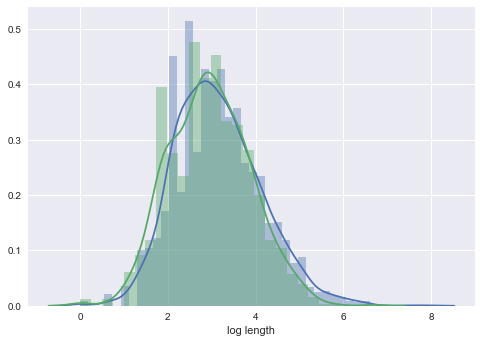

In [7]:
sns.distplot(df_train['log length'][df_train['Insult']==0])
sns.distplot(df_train['log length'][df_train['Insult']==1])

Left skewed distribution with multiple extreme outliers

In [8]:
print('length of normal comment before removing outliers:',np.mean(df_train[df_train.Insult==0]['length']))
print('length of insulting comment before removing outliers:',np.mean(df_train[df_train.Insult==1]['length']))

length of normal comment before removing outliers: 40.751897860593516
length of insulting comment before removing outliers: 29.863679694947567


In [9]:
print('length of normal comment after removing outliers:',np.mean(df_train[df_train['length']<200][df_train.Insult==0]['length']))
print('length of insulting comment after removing outliers:',np.mean(df_train[df_train['length']<200][df_train.Insult==1]['length']))

length of normal comment after removing outliers: 32.494001411432606
length of insulting comment after removing outliers: 28.261494252873565


C:\Users\zcakz\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
C:\Users\zcakz\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


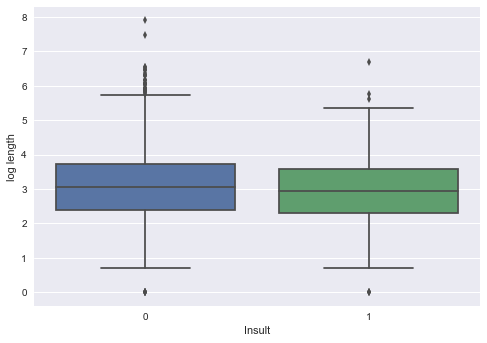

In [10]:
sns.boxplot(x='Insult', y='log length', data=df_train)

The distributions of insulting and normal comments in terms of length are slightly different

### bad word list

Using bad word list which alleged from google to count the frequency and ratio of bad words in comments

In [11]:
bad_word  = [line.rstrip('\n') for line in open('wordlist/google_bad_word.txt')]

In [12]:
df_train['bad word count']=df_train['Comment'].map(lambda x:sum([word.lower() in bad_word for word in x.split()]))
df_train['bad word ratio']=df_train['bad word count']/df_train['length']

In [13]:
print('bad word count (0/1):',np.mean(df_train[df_train.Insult==0]['bad word count']),np.mean(df_train[df_train.Insult==1]['bad word count']))
print('bad word ratio (0/1):',np.mean(df_train[df_train.Insult==0]['bad word ratio']),np.mean(df_train[df_train.Insult==1]['bad word ratio']))

bad word count (0/1): 0.3719806763285024 1.238322211630124
bad word ratio (0/1): 0.01718711142293871 0.07236876713213453


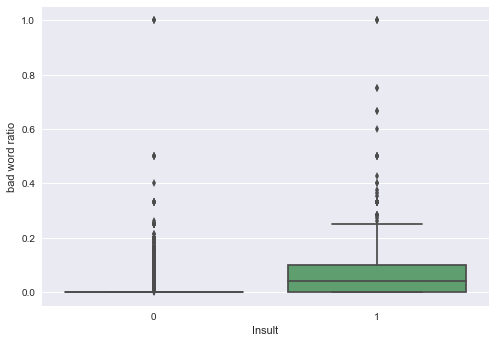

In [14]:
sns.boxplot(x='Insult', y='bad word ratio', data=df_train)

In [15]:
df_train[df_train['bad word ratio']>=0.5][df_train['Insult']==0]['Comment'].values

C:\Users\zcakz\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


array([' fucking idiots ', ' fucking hell ', ' fucking russians ',
       ' FUCK OTR ', ' fucking hotest blowjob ever ', ' Fuck ', ' Shit '], dtype=object)

In [16]:
df_train[df_train['bad word ratio']>=0.5][df_train['Insult']==1]['Comment'].values

C:\Users\zcakz\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


array([' faggot ', ' suck my dick yeaah babby pussy ',
       ' suck a dick pussy ass nigga bitch !!!  ', ' fucking savages ',
       ' Retard ', ' fuck off whore ', ' fucking idiots ',
       ' Hate that fucking asshole moron ',
       ' keep it movin bitch ass nigga ', ' suck my dick bitches ',
       ' he weak ass fuck ', ' fucking idiot !  ', ' faggot '], dtype=object)

C:\Users\zcakz\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


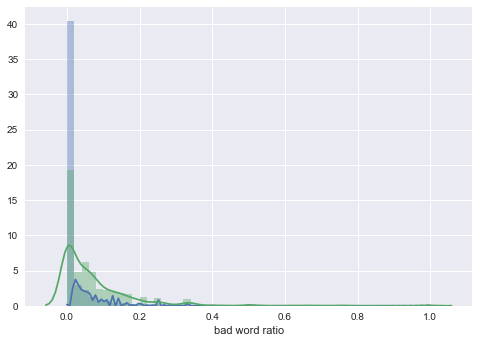

In [17]:
sns.distplot(df_train[df_train.Insult==0]['bad word ratio'])
sns.distplot(df_train[df_train.Insult==1]['bad word ratio'])

In average the insulting comment has a higher bad word count/ratio than normal comment,but majority of both count and ratio in two classes are zero. 

### Positive/Negative word list

In [22]:
strong_pos  = [line.rstrip('\n') for line in open('wordlist/strong_pos.txt')]
strong_neg  = [line.rstrip('\n') for line in open('wordlist/strong_neg.txt')]
weak_pos  = [line.rstrip('\n') for line in open('wordlist/weak_pos.txt')]
weak_neg  = [line.rstrip('\n') for line in open('wordlist/weak_neg.txt')]

* strong positive

In [27]:
df_train['strong pos count']=df_train['Comment'].map(lambda x:sum([word.lower() in strong_pos for word in x.split()]))
df_train['strong pos ratio']=df_train['strong pos count']/df_train['length']

print('strong pos count (0/1):',np.mean(df_train[df_train.Insult==0]['strong pos count']),np.mean(df_train[df_train.Insult==1]['strong pos count']))
print('strong pos ratio (0/1):',np.mean(df_train[df_train.Insult==0]['strong pos ratio']),np.mean(df_train[df_train.Insult==1]['strong pos ratio']))

strong pos count (0/1): 1.3688750862663905 0.9389895138226882
strong pos ratio (0/1): 0.03938127244648062 0.02937471037660424


* strong negative

In [26]:
df_train['strong neg count']=df_train['Comment'].map(lambda x:sum([word.lower() in strong_neg for word in x.split()]))
df_train['strong neg ratio']=df_train['strong neg count']/df_train['length']

print('strong neg count (0/1):',np.mean(df_train[df_train.Insult==0]['strong neg count']),np.mean(df_train[df_train.Insult==1]['strong neg count']))
print('strong neg ratio (0/1):',np.mean(df_train[df_train.Insult==0]['strong neg ratio']),np.mean(df_train[df_train.Insult==1]['strong neg ratio']))

strong neg count (0/1): 0.8350586611456177 1.3145853193517636
strong neg ratio (0/1): 0.021308272514421998 0.05788140792074243


* weak positive

In [28]:
df_train['weak pos count']=df_train['Comment'].map(lambda x:sum([word.lower() in weak_pos for word in x.split()]))
df_train['weak pos ratio']=df_train['weak pos count']/df_train['length']

print('weak pos count (0/1):',np.mean(df_train[df_train.Insult==0]['weak pos count']),np.mean(df_train[df_train.Insult==1]['weak pos count']))
print('weak pos ratio (0/1):',np.mean(df_train[df_train.Insult==0]['weak pos ratio']),np.mean(df_train[df_train.Insult==1]['weak pos ratio']))

weak pos count (0/1): 1.1369910282953761 0.7902764537654909
weak pos ratio (0/1): 0.02868456304936648 0.02353577026481179


* weak negative

In [29]:
df_train['weak neg count']=df_train['Comment'].map(lambda x:sum([word.lower() in weak_neg for word in x.split()]))
df_train['weak neg ratio']=df_train['weak neg count']/df_train['length']

print('weak neg count (0/1):',np.mean(df_train[df_train.Insult==0]['weak neg count']),np.mean(df_train[df_train.Insult==1]['weak neg count']))
print('weak neg ratio (0/1):',np.mean(df_train[df_train.Insult==0]['weak neg ratio']),np.mean(df_train[df_train.Insult==1]['weak neg ratio']))

weak neg count (0/1): 0.855072463768116 0.7454718779790277
weak neg ratio (0/1): 0.02048345410906595 0.025559522636694046


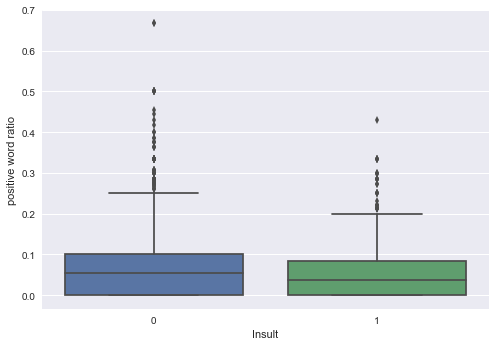

In [35]:
df_train['negative word ratio'] = df_train['weak neg ratio'] + df_train['strong neg ratio']
df_train['positive word ratio'] = df_train['weak pos ratio'] + df_train['strong pos ratio']

sns.boxplot(x='Insult', y='positive word ratio', data=df_train)

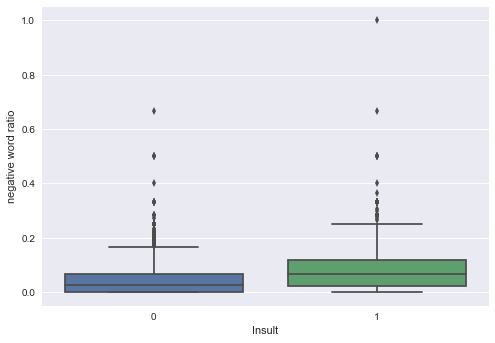

In [36]:
sns.boxplot(x='Insult', y='negative word ratio', data=df_train)

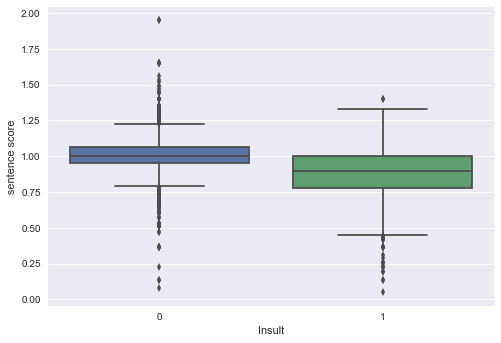

In [37]:
df_train['sentence score']= np.exp((-2*df_train['bad word count'] + (-1)*df_train['strong neg count']+ (-1)*df_train['weak neg count']\
                        + 1*df_train['weak pos count'] + 1 * df_train['strong pos count'])/df_train['length'])
    
sns.boxplot(x='Insult', y='sentence score', data=df_train)

### tf-idf similarity

Here I test if tf-idf can capture the difference between groups, by computing average tf-idf vectors of normal and insulting comments in training set, then compute the cosine similarity between each comments after tf-idf vectorisation and these two average vectors.

* unigram

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_unigram = TfidfVectorizer(stop_words='english',ngram_range=(1, 1)) 
tfidf_unigram.fit(pd.concat((df_train, df_test), axis=0, ignore_index=True)['Comment'])

tf_idf_unigram_all = tfidf_unigram.transform(df_train['Comment'])
tf_idf_unigram_normal = tfidf_unigram.transform(df_train[df_train.Insult==0]['Comment'])
tf_idf_unigram_insult = tfidf_unigram.transform(df_train[df_train.Insult==1]['Comment'])

tf_idf_unigram_normal_mean = tf_idf_unigram_normal.mean(axis=0)
tf_idf_unigram_insult_mean = tf_idf_unigram_insult.mean(axis=0)

In [ ]:
tfidf_unigram_normal_sim= [cosine_similarity(tf_idf_unigram_normal_mean, comment)[0][0] for comment in tf_idf_unigram_all]
tfidf_unigram_insult_sim= [cosine_similarity(tf_idf_unigram_insult_mean, comment)[0][0] for comment in tf_idf_unigram_all]

df_train['normal_tfidf_unigram_sim'] = tfidf_unigram_normal_sim
df_train['insult_tfidf_unigram_sim'] = tfidf_unigram_insult_sim

In [ ]:
print(np.mean(df_train[df_train.Insult==0]['normal_tfidf_unigram_sim']),np.mean(df_train[df_train.Insult==1]['normal_tfidf_unigram_sim']))
sns.boxplot(x='Insult', y='normal_tfidf_unigram_sim', data=df_train)

In [ ]:
print(np.mean(df_train[df_train.Insult==0]['insult_tfidf_unigram_sim']),np.mean(df_train[df_train.Insult==1]['insult_tfidf_unigram_sim']))
sns.boxplot(x='Insult', y='insult_tfidf_unigram_sim', data=df_train)

It seems like the average tf-idf cosine similarity of insult comments is useful

* bigram

In [ ]:
tfidf_bigram = TfidfVectorizer(stop_words='english',ngram_range=(2, 2)) 
tfidf_bigram.fit(pd.concat((df_train, df_test), axis=0, ignore_index=True)['Comment'])

tf_idf_bigram_all = tfidf_bigram.transform(df_train['Comment'])
tf_idf_bigram_normal = tfidf_bigram.transform(df_train[df_train.Insult==0]['Comment'])
tf_idf_bigram_insult = tfidf_bigram.transform(df_train[df_train.Insult==1]['Comment'])

tf_idf_bigram_normal_mean = tf_idf_bigram_normal.mean(axis=0)
tf_idf_bigram_insult_mean = tf_idf_bigram_insult.mean(axis=0)

In [ ]:
tfidf_bigram_normal_sim= [cosine_similarity(tf_idf_bigram_normal_mean, comment)[0][0] for comment in tf_idf_bigram_all]
tfidf_bigram_insult_sim= [cosine_similarity(tf_idf_bigram_insult_mean, comment)[0][0] for comment in tf_idf_bigram_all]

df_train['normal_tfidf_bigram_sim'] = tfidf_bigram_normal_sim
df_train['insult_tfidf_bigram_sim'] = tfidf_bigram_insult_sim

In [ ]:
print(np.mean(df_train[df_train.Insult==0]['normal_tfidf_bigram_sim']),np.mean(df_train[df_train.Insult==1]['normal_tfidf_bigram_sim']))
sns.boxplot(x='Insult', y='normal_tfidf_bigram_sim', data=df_train)

In [ ]:
print(np.mean(df_train[df_train.Insult==0]['insult_tfidf_bigram_sim']),np.mean(df_train[df_train.Insult==1]['insult_tfidf_bigram_sim']))
sns.boxplot(x='Insult', y='insult_tfidf_bigram_sim', data=df_train)

### language model

In [ ]:
import nltk
from nltk import word_tokenize
from nltk.util import ngrams

def trigram_compute(x):
    trigram_lst = []
    for comment in x:
        token = word_tokenize(comment)
        trigrams=ngrams(token,3)
        for i in trigrams:
            trigram_lst.append(i)
    return trigram_lst

def normal_language_model_prob(x):
    prob_sum = 0
    for i in x:
        prob_sum += normal_kneser_ney.prob(i)
    return prob_sum

def insult_language_model_prob(x):
    prob_sum = 0
    for i in x:
        prob_sum += insult_kneser_ney.prob(i)
    return prob_sum

Compute language model for normal comments

In [283]:
normal_trigram_lst = trigram_compute(df_train[df_train.Insult==0]['Comment'])
normal_freq_dist = nltk.FreqDist(normal_trigram_lst)
normal_kneser_ney = nltk.KneserNeyProbDist(normal_freq_dist)

C:\Users\zcakz\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: DeprecationWarning: generator 'ngrams' raised StopIteration


Compute language model for insulting comments

In [284]:
insult_trigram_lst = trigram_compute(df_train[df_train.Insult==1]['Comment'])
insult_freq_dist = nltk.FreqDist(insult_trigram_lst)
insult_kneser_ney = nltk.KneserNeyProbDist(insult_freq_dist)

C:\Users\zcakz\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: DeprecationWarning: generator 'ngrams' raised StopIteration


Compute Probability 
* given language models of normal comments after log(x+0.5) transformation

C:\Users\zcakz\Anaconda3\lib\site-packages\ipykernel\__main__.py:16: DeprecationWarning: generator 'ngrams' raised StopIteration


1.513904731790569 0.015178988978441672


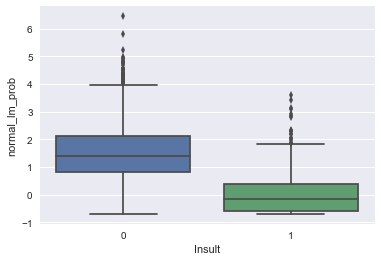

In [285]:
df_train['normal_lm_prob']=df_train['Comment'].map(lambda x: np.log(normal_language_model_prob(ngrams(word_tokenize(x),3))+0.5))

print(np.mean(df_train[df_train.Insult==0]['normal_lm_prob']),np.mean(df_train[df_train.Insult==1]['normal_lm_prob']))
sns.boxplot(x='Insult', y='normal_lm_prob', data=df_train)

* given language models of insulting comments after log(x+0.5) transformation

C:\Users\zcakz\Anaconda3\lib\site-packages\ipykernel\__main__.py:22: DeprecationWarning: generator 'ngrams' raised StopIteration


-0.15214735810739202 1.4290225739545654


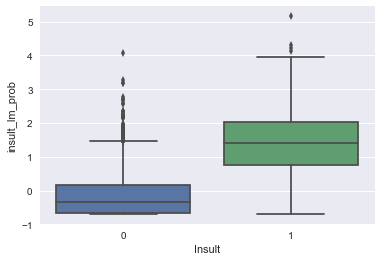

In [286]:
df_train['insult_lm_prob']=df_train['Comment'].map(lambda x: np.log(insult_language_model_prob(ngrams(word_tokenize(x),3))+0.5))

print(np.mean(df_train[df_train.Insult==0]['insult_lm_prob']),np.mean(df_train[df_train.Insult==1]['insult_lm_prob']))
sns.boxplot(x='Insult', y='insult_lm_prob', data=df_train)